Neste caderno, treinaremos o[ método Cox-PH](https://jmlr.org/papers/volume20/18-424/18-424.pdf) , também conhecido como [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1) . Usaremos os conjuntos de dados METABRIC como exemplo.

Uma introdução mais detalhada ao pycoxpacote pode ser encontrada neste [caderno](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) sobre o LogisticHazardmétodo.

O principal benefício que o Cox-CC (e os outros métodos de Cox) tem sobre o Logistic-Hazard é que ele é um método de tempo contínuo, o que significa que não precisamos discretizar a escala de tempo.

In [1]:
# !pip install lifelines       # modelo convecional cox
# !pip install pycox           # pycox (baseado em PyTorch)
# !pip install scikit-survival # scikit-survival (integra com scikit-learn)
# !pip install scipy==1.10.1
# ! pip install sklearn-pandas #Uncomment to install `sklearn-pandas`

# Depois reniciar o ambiente de execução

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv


In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

##Conjunto de dados
- Carregamos o conjunto de dados METABRIC e dividimos em treinamento, teste e validação.

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [5]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


##Transformações de recursos
Temos 9 covariáveis, além das durações e indicadores de eventos.

- Padronizaremos as 5 covariáveis ​​numéricas e deixaremos as variáveis ​​binárias como estão. As variáveis ​​precisam ser do tipo 'float32', conforme exigido pelo PyTorch.

In [6]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

Não precisamos de transformações de rótulos

In [8]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [9]:
val.shapes()

((305, 9), ((305,), (305,)))

- Com TupleTree(os resultados de tt.tuplefy), podemos facilmente repetir o conjunto de dados de validação várias vezes. Isso será útil para reduzir a variância da perda de validação, já que a perda de validação de CoxCCnão é determinística.

In [10]:
val.repeat(2).cat().shapes()

((610, 9), ((610,), (610,)))

##Rede neural
- Criamos um MLP simples com duas camadas ocultas: ativações ReLU, norma de lote e dropout. Aqui, usamos apenas a torchtuples.practical.MLPVanilla rede para fazer isso.

Observe que definimos out_features como 1 e que não temos output_bias.

In [11]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

##Treinando o modelo
- Para treinar o modelo, precisamos definir um otimizador. Você pode escolher qualquer torch.optimotimizador, mas aqui usamos um de , tt.optim pois ele tem algumas funcionalidades adicionais. Usamos o Adam otimizador, mas em vez de escolher uma taxa de aprendizado, usaremos o esquema proposto por [Smith em 2017](https://arxiv.org/pdf/1506.01186) para encontrar uma taxa de aprendizado adequada com model.lr_finder. Veja esta publicação para uma explicação.

In [12]:
model = CoxPH(net, tt.optim.Adam)

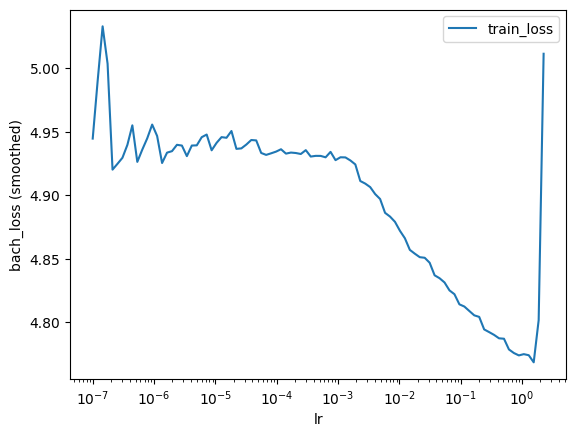

In [13]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [14]:
lrfinder.get_best_lr()

0.15556761439304817

Muitas vezes, essa taxa de aprendizagem é um pouco alta, então a definimos manualmente para 0,01

In [15]:
model.optimizer.set_lr(0.01)

Incluímos o EarlyStopping retorno de chamada para interromper o treinamento quando a perda de validação parar de melhorar. Após o treinamento, esse retorno de chamada também carregará o modelo com melhor desempenho em termos de perda de validação.

In [16]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [19]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7473,	val_loss: 3.9412
1:	[0s / 0s],		train_loss: 4.6880,	val_loss: 3.9380
2:	[0s / 0s],		train_loss: 4.6413,	val_loss: 3.9437
3:	[0s / 0s],		train_loss: 4.6102,	val_loss: 3.9427
4:	[0s / 0s],		train_loss: 4.6077,	val_loss: 3.9328
5:	[0s / 0s],		train_loss: 4.5807,	val_loss: 3.9327
6:	[0s / 0s],		train_loss: 4.5912,	val_loss: 3.9441
7:	[0s / 0s],		train_loss: 4.5547,	val_loss: 3.9270
8:	[0s / 0s],		train_loss: 4.5556,	val_loss: 3.9250
9:	[0s / 0s],		train_loss: 4.5763,	val_loss: 3.9321
10:	[0s / 1s],		train_loss: 4.5493,	val_loss: 3.9433
11:	[0s / 1s],		train_loss: 4.5647,	val_loss: 3.9443
12:	[0s / 1s],		train_loss: 4.5436,	val_loss: 3.9558
13:	[0s / 1s],		train_loss: 4.5419,	val_loss: 3.9481
14:	[0s / 1s],		train_loss: 4.5318,	val_loss: 3.9430
15:	[0s / 1s],		train_loss: 4.5572,	val_loss: 3.9440
16:	[0s / 1s],		train_loss: 4.5308,	val_loss: 3.9473
17:	[0s / 1s],		train_loss: 4.5415,	val_loss: 3.9534
18:	[0s / 1s],		train_loss: 4.5244,	val_loss: 3.9596
CPU

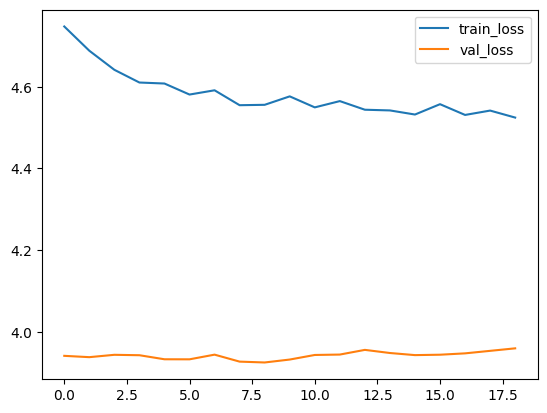

In [20]:
_ = log.plot()

Podemos obter o logaritmo parcial da verossimilhança
We can get the partial log-likelihood

In [21]:
model.partial_log_likelihood(*val).mean()

-4.992127

##Previsão
- Para avaliação, precisamos primeiro obter estimativas de sobrevivência para o conjunto de teste. Isso pode ser feito com model.predict_surv which retorna um array de estimativas de sobrevivência ou com model.predict_surv_df which retorna as estimativas de sobrevivência como um dataframe.

- Entretanto, como CoxCCé semiparamétrico, primeiro precisamos obter as estimativas de risco de base não paramétricas com compute_baseline_hazards.

- Observe que, para grandes conjuntos de dados, o sampleargumento pode ser usado para estimar o risco de base em um subconjunto.

In [22]:
_ = model.compute_baseline_hazards()

In [23]:
surv = model.predict_surv_df(x_test)

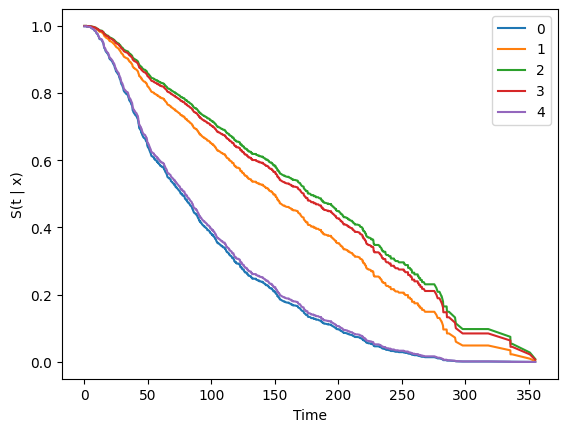

In [24]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


##Avaliação
- Podemos usar a EvalSurvclasse para avaliar a concordância, o escore de Brier e a verossimilhança logarítmica binomial. A configuração censor_surv='km' significa que estimamos a distribuição de censura de Kaplan-Meier no conjunto de teste.

In [25]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [26]:
ev.concordance_td()

0.6531403627733514

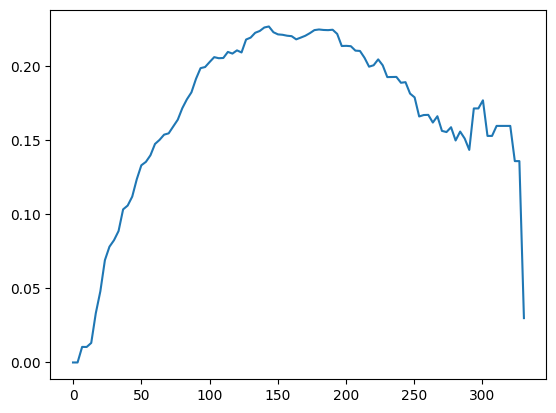

In [27]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [28]:
ev.integrated_brier_score(time_grid)

0.16878323712254112

In [29]:
ev.integrated_nbll(time_grid)

0.49928743963505695